# Clustering Analysis of Korean Restaurants in NYC
### IBM Applied Data Science Capstone
### Author: Soomin Kim

# 1. Introduction
## 1.1 Background
New York City is the most populated city in the United States. It is also one of the most ethnically, linguistically, and culturally diverse cities in the world. About 36% of the city’s population are foreign-born; 800 languages are spoken in the city; dozens of ethnic enclaves have developed throughout its neighborhoods - from Little Guyana, Koreatown, Little India, Little Odessa, Chinatown, Little Australia, Little Poland to Little Italy. 

More specifically, the City is home to more than 100,000 ethnic Koreans, which contributes to the New York metropolitan area containing the second-largest population of Koreans outside of Korea. Given its dense Korean population and a growing interest in K-food business worldwide, there are ample opportunities to expand Korean restaurant business in New York City. 

## 1.2 Aim
This project aims to use K-Means Clustering to cluster neighborhoods based on similar mean frequency of Korean restaurants, then recommend the best location (neighborhood) to open a Korean restaurant using the following criteria:
- small density of Korean restaurants (not already too crowded)
- proximity to the city center

## 1.3 Target Audience
This project will provide great insight for anyone - entrepreneurs, business owners, investors - who are looking to start or expand their Korean restaurant business in New York City.


# 2. Data Acquisition and Cleaning

**Download necessary libraries**

In [2]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Data 1: Neighborhood and Locations Data

Collect the New York City Neighborhoods Data from 
https://cocl.us/new_york_dataset. This data contains a total of 5 boroughs and 306 neighborhoods as well as the latitude and longitude coordinates of each neighborhood in New York City.

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset

**Load and explore data**

In [63]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

# newyork_data

Notice how all the relevant data is in the features key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [5]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.


In [6]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

**Tranform the data into a pandas dataframe**

In [7]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [8]:
# take a look at the empty dataframe to confirm that the columns are as intended.
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Loop through the data and fill the dataframe one row at a time.


In [9]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [10]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [11]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [13]:
# find out how many neighborhoods are in each borough
neighborhoods_count = pd.DataFrame(neighborhoods.groupby('Borough').count()['Neighborhood'])
neighborhoods_count

,Neighborhood
Borough,
Bronx,52
Brooklyn,70
Manhattan,40
Queens,81
Staten Island,63


**Use geopy library to get the latitude and longitude values of New York City.**


To define an instance of the geocoder, define a user_agent. Name our agent ny_explorer, as shown below:

In [14]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


## Data 2: Neighborhoods and Venues Data

The Foursquare API provides comprehensive location data, including data based on location, keyword, user, amongst others. Use the Foursquare API to get all the venues in the neighborhoods of New York City, eventually to discover and cluster Korean restaurants in the neighborhoods.

In [18]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'GCR1BF234O3J2NPFJVBJZUWH1OEN1L1W5VVE5OWK1UFO0M2T' # your Foursquare ID
CLIENT_SECRET = '0CIXQ2PM043RMWPIFTFK24CQ3VXJXNJXRL5352DCGUTQENPV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentials:')
print('CLIENT_ID: ' + 'GCR1BF234O3J2NPFJVBJZUWH1OEN1L1W5VVE5OWK1UFO0M2T')
print('CLIENT_SECRET:' + '0CIXQ2PM043RMWPIFTFK24CQ3VXJXNJXRL5352DCGUTQENPV')

Your credentials:
CLIENT_ID: GCR1BF234O3J2NPFJVBJZUWH1OEN1L1W5VVE5OWK1UFO0M2T
CLIENT_SECRET:0CIXQ2PM043RMWPIFTFK24CQ3VXJXNJXRL5352DCGUTQENPV


**Get top 100 venues that are within a radius of 500 meters from NYC**

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [62]:
nyc_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'], 
                                   longitudes=neighborhoods['Longitude'])

Check the size of the resulting dataframe

In [21]:
print(nyc_venues.shape)
nyc_venues.head()

(9495, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Subway,40.890468,-73.849152,Sandwich Place
4,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy


Check how many venues are there per neighborhood

In [61]:
# nyc_venues.groupby('Neighborhood').count()

# 3. Exploratory Data Analysis

**3.1 Visualize a map of New York City by Neighborhood.**

Use the folium package to visualize a map of New York with neighborhoods superimposed on top on a leaflet map. More specifically, use the CircleMarker() function to color-code boroughs - it provides a clearer understanding of where each borough is located.

In [15]:
# Create list with Boroughs
boroughs = neighborhoods['Borough'].unique().tolist()
boroughs

['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island']

In [16]:
# Color categorize each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [17]:
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], 
                                           neighborhoods['Longitude'],
                                           neighborhoods['Borough'], 
                                           neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

**3.2 Number of Unique Venues and Korean Restaurants in NYC:**

Check how many unique venues there are

In [93]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))

There are 434 uniques categories.


Check how many Korean Restaurants there are

In [94]:
"Korean Restaurant" in nyc_venues['Venue Category'].unique() # True/False

True

In [95]:
nyc_venues['Venue Category'].value_counts()['Korean Restaurant']

55

Result: 
- 434 unique venue categories, including Korean Restaurants
- 55 Korean Restaurants in New York

### One Hot Encoding
To divide New York City into clusters of neighborhoods with a similar number of Korean Restaurants, first transform the categorical variables within nyc_venues to numerical ones (nyc_onehot). To do so, use the One Hot Encoding technique, using the pd.get_dummies function within the Pandas package. 

In [4]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood'] 

# move neighborhood column to the first column
first_col = nyc_onehot.pop("Neighborhood")
nyc_onehot.insert(0, "Neighborhood", first_col)

print(nyc_onehot.shape)
nyc_onehot.head()

Next, calculate the mean of all venue categories by neighborhoods to analyze the data by neighborhood

In [138]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
print(nyc_grouped.shape)
nyc_grouped.head()

(302, 434)


,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Gym,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera Hou

Then, extract only the Neighborhood and Korean Restaurant columns for further analysis

In [139]:
korean = nyc_grouped[['Neighborhood', 'Korean Restaurant']]
korean.head()

,Neighborhood,Korean Restaurant
0,Allerton,0.0
1,Annadale,0.0
2,Arden Heights,0.0
3,Arlington,0.0
4,Arrochar,0.0


**3.3 Top 10 New York Neighborhoods with the Highest Number of Korean Restaurants:**

Data visualization to discover where these 55 Korean Restaurants are mostly located. The Top 10 New York neighborhoods with the highest number of Korean Restaurants shown below. Results show that Murray Hill has the highest number (15), closely followed by Midtown South (14). There is a significant dip in number from the third highest neighborhood, Oakland
Gardens, which has 4. This is followed by East Village and Flushing, each with 3. Sunnyside Gardens and Little Neck each has 2, and the last three - Utopia, Park Slope, Civic Center - each has 1 Korean Restaurant.

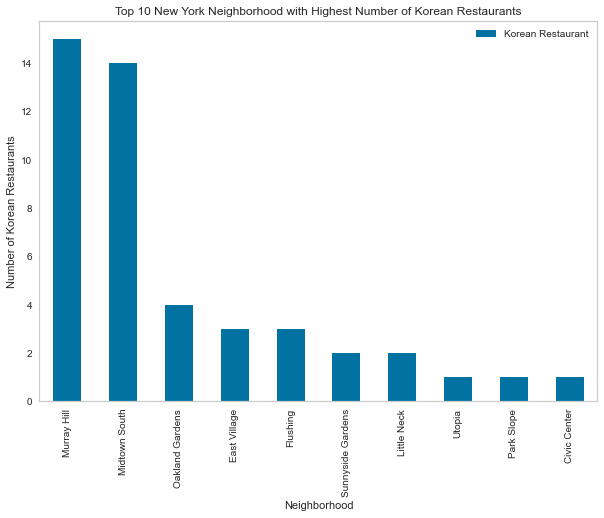

In [96]:
top10 = pd.DataFrame(nyc_onehot.groupby('Neighborhood')['Korean Restaurant'].sum())
top10 = top10.sort_values(by='Korean Restaurant', ascending=False)

top10.iloc[:10].plot(kind='bar', figsize=(10,7))
plt.xlabel('Neighborhood')
plt.ylabel('Number of Korean Restaurants')
plt.title('Top 10 New York Neighborhood with Highest Number of Korean Restaurants')
plt.grid(False)

plt.show()

Murray Hill has the highest number of Korean Restaurants, closely followed by Midtown South. There is a significant drop in the number of Korean Restaurants from the third highest neighborhood.

# 4. Machine Learning

### K-means clustering

Use the K-Means clustering to cluster the neighborhoods based on neighborhoods with similar mean frequencies of Korean Restaurants.

First, using the KElbowVisualizer, identify the optimal number of clusters (best K value) by fitting the model with a range of K values from 1 to 10. The resulting line graph resembles an arm with an "elbow" (the point of inflection on the curve), annotated with a dashed line, which is where the model fits best. In the graph below, the line annotating the "elbow" is at k = 3. This means that the optimum number of clusters is 3.

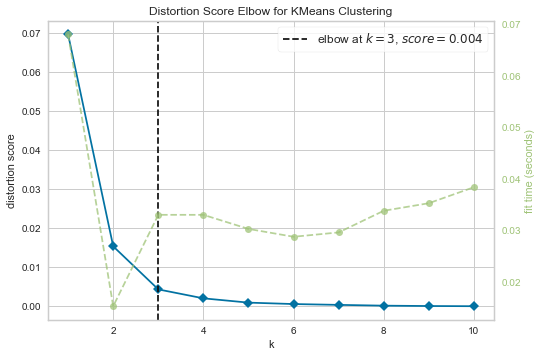

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [140]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

korean_clustering = korean.drop('Neighborhood', 1)

# run Elbow method using k-means clustering model and visualize
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,11))

visualizer.fit(korean_clustering) # fit the data to the visualizer
visualizer.poof() # display graph

In [141]:
kclusters = 3

korean_clustering = korean.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(korean_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Run K-Means clustering method that creates 3 clusters of neighborhoods based on the similar mean frequencies of Korean Restaurants. Each cluster is labelled as 0, 1, or 2. Compile these into a new column, ‘Cluster Labels’, and merge the column with the korean dataframe into kor_merged dataframe:

In [142]:
# create a dataframe of korean restaurants in each neighborhood with cluster labels
kor_merged = korean.copy()

# add clustering labels
kor_merged['Cluster Labels'] = kmeans.labels_

In [143]:
kor_merged.head()

,Neighborhood,Korean Restaurant,Cluster Labels
0,Allerton,0.0,0
1,Annadale,0.0,0
2,Arden Heights,0.0,0
3,Arlington,0.0,0
4,Arrochar,0.0,0


In [144]:
kor_merged.shape

(302, 3)

Next: Merge the above table with our data frame of Korean Restaurants in New York to get coordinates of all neighborhoods.

Before joining this cluster label and mean frequency of Korean Restaurant data with location data, the latter should be in good shape with only the necessary columns. To ensure that I have one location data (longitude and latitude values) for each neighborhood, create a new dataframe nyc_venues_grouped that had mean longitude and latitude values for each neighborhood:

In [145]:
# check nyc_venues dataframe
nyc_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Subway,40.890468,-73.849152,Sandwich Place
4,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy


In [146]:
# calculate mean latitude and longitude values for each neighborhood
nyc_venues_grouped = nyc_venues.groupby('Neighborhood').mean().reset_index()
nyc_venues_grouped.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude
0,Allerton,40.865788,-73.859319,40.865071,-73.859155
1,Annadale,40.538114,-74.178549,40.541053,-74.177623
2,Arden Heights,40.549286,-74.185887,40.551498,-74.184475
3,Arlington,40.635325,-74.165104,40.635079,-74.166269
4,Arrochar,40.596313,-74.067124,40.595970,-74.065469


Since I won't need the average venue location data anymore for neighborhood analysis, drop the last two columns:

In [147]:
# drop 'Venue Latitude' and 'Venue Longitude' columns
nyc_venues_grouped = nyc_venues_grouped.drop(['Venue Latitude','Venue Longitude'], axis=1)
nyc_venues_grouped.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,Allerton,40.865788,-73.859319
1,Annadale,40.538114,-74.178549
2,Arden Heights,40.549286,-74.185887
3,Arlington,40.635325,-74.165104
4,Arrochar,40.596313,-74.067124


Join kor_merged (cluster labelled data) with nyc_venues_grouped
(neighborhood location data) to add latitude and longitude values for each neighborhood:

In [148]:
# merge korean restaurant mean frequency and cluster labelled data with location data
kor_merged = kor_merged.join(nyc_venues_grouped.set_index("Neighborhood"), on="Neighborhood")

print(kor_merged.shape)
kor_merged.head()

(302, 5)


,Neighborhood,Korean Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude
0,Allerton,0.0,0,40.865788,-73.859319
1,Annadale,0.0,0,40.538114,-74.178549
2,Arden Heights,0.0,0,40.549286,-74.185887
3,Arlington,0.0,0,40.635325,-74.165104
4,Arrochar,0.0,0,40.596313,-74.067124


Join the kor_merged with neighborhoods data that contains boroughs information.

In [175]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [64]:
# add borough
kor_merged = neighborhoods.join(kor_merged.set_index("Neighborhood"), on="Neighborhood")
# kor_merged

Drop the latitude and longitude columns of kor_merged data, which are inaccurate for same-named neighborhoods, and keep the location data obtained from neighborhoods data to ensure all neighborhoods, regardless of identical names, are in accurate representation of their location:

In [65]:
# drop neighborhood latitude and neighborhood longitude columns that have same values for same-named neighborhoods even if they are in different boroughs
kor_merged = kor_merged.drop(['Neighborhood Latitude','Neighborhood Longitude'], axis=1)
# kor_merged

### Visualize the Clusters

Use the folium package to create a colored map displaying 3 clusters in NYC:
- Cluster 0: Red
- Cluster 1: Purple
- Cluster 2: Aquamarine

In [180]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kor_merged['Latitude'], kor_merged['Longitude'], kor_merged['Neighborhood'], kor_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine the Clusters

In [163]:
borough = neighborhoods[['Borough','Neighborhood']]
borough.head()

,Borough,Neighborhood
0,Bronx,Wakefield
1,Bronx,Co-op City
2,Bronx,Eastchester
3,Bronx,Fieldston
4,Bronx,Riverdale


### Cluster 0 (Red)

In [66]:
# Red
cluster0 = kor_merged.loc[kor_merged['Cluster Labels']==0]
# cluster0 = pd.merge(borough, cluster0, on = "Neighborhood")
cluster0 = cluster0.sort_values('Korean Restaurant', ascending=False)
# cluster0

In [182]:
cluster0['Korean Restaurant'].mean()

0.0002611378002325322

Cluster 0 contains neighborhoods with the smallest density of Korean Restaurants, with a mean of 0.0003 (4dp) Korean Restaurant average occurrences across all selected neighborhoods in this cluster. These neighborhoods are all spread out across all five boroughs. Of the 291 neighborhoods in this cluster, however, there are only 6 neighborhoods with non-zero mean occurrence of Korean Restaurants. These are neighborhoods of Brooklyn, Queens, Manhattan. Consequently, the other two boroughs, Staten Island and Bronx, in this cluster had zero mean occurrences of Korean Restaurants.

### Cluster 1 (Purple)

In [67]:
# Purple
cluster1 = kor_merged.loc[kor_merged['Cluster Labels']==1]
# cluster1 = pd.merge(borough, cluster1, on = "Neighborhood")
cluster1 = cluster1.sort_values('Korean Restaurant', ascending=False)
# cluster1

In [184]:
cluster1['Korean Restaurant'].mean()

0.12974452554744526

Cluster 1 contains neighborhoods with the highest density of Korean Restaurants, with a mean of 0.1297 (4dp) Korean Restaurant average occurrences. There are a total of 4 neighborhoods in this cluster, all from either Queens or Manhattan. The neighborhood with the highest frequency of Korean Restaurant was Oakland Gardens of Queens with 0.1600 (4dp), followed by Midtown South of Manhattan with 0.1400 (4dp). The third and fourth neighborhoods were Murray Hill of Manhattan and that of Queens, both with 0.1095 (4dp) Korean Restaurant average occurrence.

### Cluster 2 (Aquamarine)

In [68]:
# Turquoise
cluster2 = kor_merged.loc[kor_merged['Cluster Labels']==2]
# cluster2 = pd.merge(borough, cluster2, on = "Neighborhood")
cluster2 = cluster2.sort_values('Korean Restaurant', ascending=False)
# cluster2

In [186]:
cluster2['Korean Restaurant'].mean()

0.03290309590709988

Cluster 2 contained neighborhoods with the second highest density of Korean Restaurants, with a mean of 0.0329 (4dp). Of the 11 neighborhoods selected in this cluster, there were 7 from Queens, 2 from Brooklyn, 1 from Manhattan, and 1 from Staten Island. In particular, Queens stood out as the borough with the highest density of Korean Restaurants, with its 4 neighborhoods having the top 4 mean occurrence scores in this cluster

## Cluster Analysis using Data Visualization

Visualize these outcomes to aid understanding. 

Create two independent bar graphs, the first showing the number of neighborhoods per cluster and the second showing the mean number of Korean Restaurants per cluster:

### 1. Number of Neighborhoods per Cluster

In [187]:
# count how many neighborhoods there are in each cluster
kor_merged['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)

,Cluster Labels
0,291
1,4
2,11


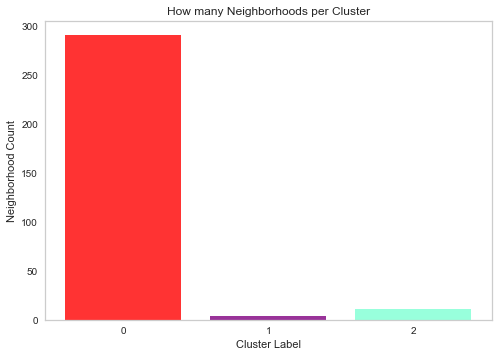

In [188]:
objects = (0, 1, 2)
y_pos = np.arange(len(objects))
performance = kor_merged['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine'])
plt.xticks(y_pos, objects)
plt.ylabel('Neighborhood Count')
plt.xlabel('Cluster Label')
plt.title('How many Neighborhoods per Cluster')
plt.grid(False)

plt.show()

### 2. Mean Number of Korean Restaurants per Cluster

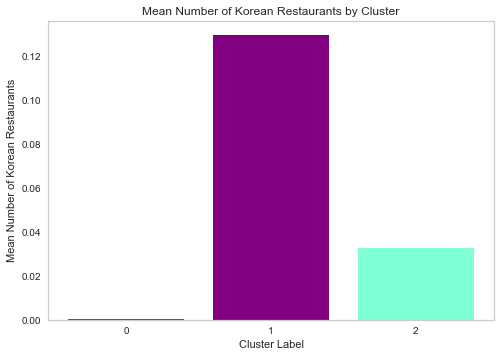

In [189]:
mean_clusters = [cluster0['Korean Restaurant'].mean(),
                cluster1['Korean Restaurant'].mean(),
                cluster2['Korean Restaurant'].mean()]

mean_clusters

cluster_no = (0,1,2)
x = np.arange(len(cluster_no))
y = mean_clusters

plt.bar(x, y, align='center', color=['red', 'purple', 'aquamarine'])
plt.xticks(x, cluster_no)
plt.xlabel('Cluster Label')
plt.ylabel('Mean Number of Korean Restaurants')
plt.title('Mean Number of Korean Restaurants by Cluster')
plt.grid(False)

plt.show()

In [192]:
cluster0['Borough'].value_counts().to_frame().sort_index(ascending=True)
# cluster0[cluster0['Borough']=='Staten Island']
# cluster0[cluster0['Borough']=='Bronx']

,Borough
Bronx,52
Brooklyn,68
Manhattan,37
Queens,72
Staten Island,62
